# <div align="center"><font color='green'> COSC 2673/2793 | Machine Learning  </font></div>
## <div align="center"> <font color='green'> Assignment 2: **Cell Classification**</font></div>

- A well justified evaluation framework.
- Pre-processing the data set to make it suitable for providing to various machine learning algorithms.
- Carefully selected and justified baseline model(s).
- Hyper-parameter setting and tuning to refine the model.
- Analysing model and outputs & interpreting the trained models



This originial study provides 100 histology images related to colon cancer. Most successful approaches to training deep learning models on such histology images perform human-guided feature selection by extracting a small number of patches, via a process known as **patch extraction**, and providing them with patch labels for whether they are cancerous, and its cell type. 

CRCHistoPhenotypes was the basis of our dataset providing 27x27 pixel size patches, and divided into 2 datasets:
 - **Main data**: 
    - 9896 patches
    - Class labels: 'isCancerous' and 'cellType'
- **Extra data**:
    - 10384 patches
    - Class labels: 'isCancerous'





TODO: softmax CNN + NEP for classifying cell types

TODO: transfer learning, use one pre-trained model as basis for 2nd one, aka use extraData classification for mainData classification 
TODO: how to use the extra data:
Another approach is to use the extraData dataset as a source of unlabeled data for semi-supervised learning. In this approach, you can use the extraData dataset to train an unsupervised model, such as an autoencoder, to learn the underlying features of the cell images. Then, you can use the learned features as inputs to a supervised model, which can be trained on the labeled data from the mainData dataset. This approach can help the model learn more robust representations of the cell images, which can lead to better classification performance even with limited labeled data.
TODO: visual transformers?? 16x16 better kernel, more resources to train

TODO:
Eval metrics: Weighted average F1-score, Multi-class AUC, Epithelial Precision (for isCancerous) 


Bibliography:
"Adam: A Method for Stochastic Optimization"
Original paper: http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf
https://www.tensorflow.org/api_docs/python/tf/keras/metrics
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy/SGD
https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

original paper (used): http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf
rccnet (used): https://arxiv.org/pdf/1810.02797.pdf
https://ieeexplore.ieee.org/document/9715122
https://www.frontiersin.org/articles/10.3389/fmed.2019.00264/full
https://arxiv.org/pdf/1802.00752.pdf
https://ieeexplore.ieee.org/document/8634690
https://arxiv.org/pdf/2009.03878.pdf

In [710]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.utils import resample

import tensorflow
import keras
from keras.initializers import RandomNormal, Zeros
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Activation, add, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten, Dropout
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

# for visualizing the model using plot_model
# !pip install pydot

2 datasets:
Main data: used for cell type classification
Full data: Combined main+extra data used for isCancerous classification, and to pretrain for cell type. Drop cell type columns.
We will not merge the datasets yet, as we need to implement our splitting strategy first.


In [778]:
main_data = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
extra_data = pd.read_csv('Image_classification_data/data_labels_extraData.csv')


# convert to string type for future classification
main_data['isCancerous'] = main_data['isCancerous'].astype(str)
extra_data['isCancerous'] = extra_data['isCancerous'].astype(str)
main_data['cellType'] = main_data['cellType'].astype(str)

print(main_data['cellType'].value_counts())
print(main_data['cellTypeName'].value_counts())
print(main_data['isCancerous'].value_counts())

print("Dataset shape")
print(main_data.shape)
print(extra_data.shape)


2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64
0    5817
1    4079
Name: isCancerous, dtype: int64
Dataset shape
(9896, 6)
(10384, 4)


In [603]:

main_data.head()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64
0    5817
1    4079
Name: isCancerous, dtype: int64


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [527]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


## Image averaging
Epithelial have  the weakest nuclei positioning, as the center position is blurred, while inflammatory cells have the strongest.
The colour of epithelial cells is a stronger hue of purple, which may contribute to its morphology to distinguish its type.

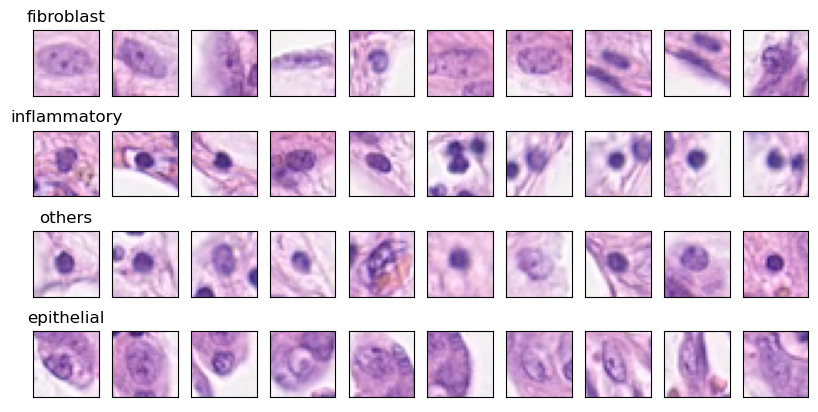

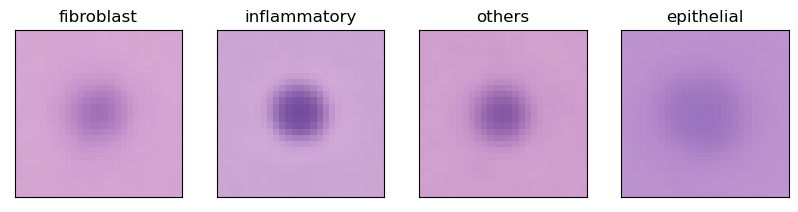

In [528]:
def cell_image(imageName):
    return Image.open('Image_classification_data/patch_images/' + imageName)


rows = 20
# Source: Week 4 Lecture Q and A
def plot_cells(data):
    cell_types = main_data['cellTypeName'].unique()
    plt.figure(figsize=(10,5))
    for i, cell_type in enumerate(cell_types):
        cell_type_data = data[data['cellTypeName'] == cell_type][:10] 
        for j, image_name in enumerate(cell_type_data['ImageName']):
            plt.subplot(len(cell_types), 10, (i*10)+j+1) 
            plt.imshow(cell_image(image_name)) 
            plt.xticks([])
            plt.yticks([])
            if j==0:
                plt.title(cell_type) 
    plt.show()

# Get the average cell image from all cell images 
# filter the data to only include images with the chosen cell type
def plot_image_average(data):
    cell_types = main_data['cellTypeName'].unique()
    plt.figure(figsize=(10,10))
    for i, cell_type in enumerate(cell_types):
        cell_type_data = data[data['cellTypeName'] == cell_type]
        image_arrays = [np.array(cell_image(image_name)) for image_name in cell_type_data['ImageName']]
        average_array = np.mean(image_arrays, axis=0).astype(np.uint8)
        average_image = Image.fromarray(average_array)
        plt.subplot(len(cell_types), 4, i+1) 
        plt.imshow(average_image)
        plt.xticks([])
        plt.yticks([])
        plt.title(cell_type)
    plt.show()

plot_cells(main_data)
plot_image_average(main_data)

"In classification, morphology of nuclei (shape, size, color, and texture) is
necessary to distinguish between different types of them. Raw RGB color intensities which constitute the overall visual
appearance of nuclei were, thus, chosen as input features to
softmax CNN for each patch."
Based on paper, only 1 channel was used for colour intensity. But as mentioned, the colour is also necessary. Epithelial cells appear to have a separate colour entirely, and seems to have a strong correlation to cancerous cells. For this reason, improvements to the CNN's baseline involves making the input shape have 3 channels.

# Get value counts of categorical variables
for column in {'cellTypeName', 'cellType', 'isCancerous'}:
    print(pd.value_counts(data[column]))
data.head()

# Get total unique patients
patients = len(data['patientID'].unique())
print(f"There are {patients} unique patients")

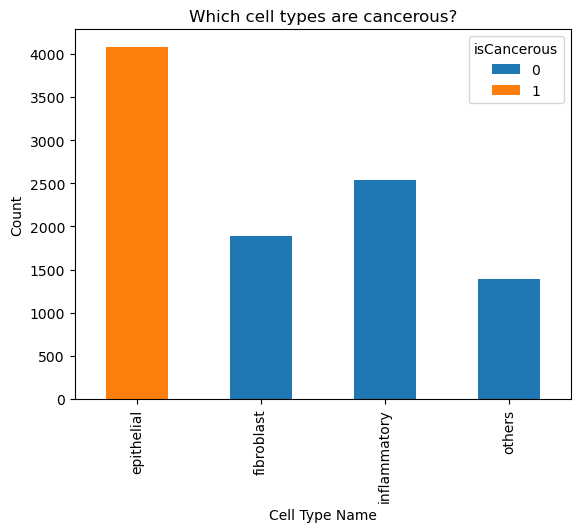

In [529]:
# Stacked bar chart 
grouped_data = main_data.groupby(['cellTypeName', 'isCancerous']).size().reset_index(name='count')
pivoted_data = grouped_data.pivot(index='cellTypeName', columns='isCancerous', values='count')
pivoted_data.plot(kind='bar', stacked=True)
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.title('Which cell types are cancerous?')
plt.show()

The dataset indicates that most cancer cells are epithelial in nature. However, the other cells may still play a role in cancer development. An example of this is inflammation cells causing chronic inflammation, which can damage DNA and other cellular components leading to cancer. [Link](https://www.cancer.gov/news-events/cancer-currents-blog/2022/reducing-inflammation-to-treat-cancer#:~:text=In%20a%20normal%20inflammatory%20response,that%20could%20lead%20to%20cancer)

TODO:
For this, it will be useful to identify the distribution of these cells per patient.

Other points:
- the extra data set may give better insight into classifying. first use both to classify cell type, then use to predict isCancerous

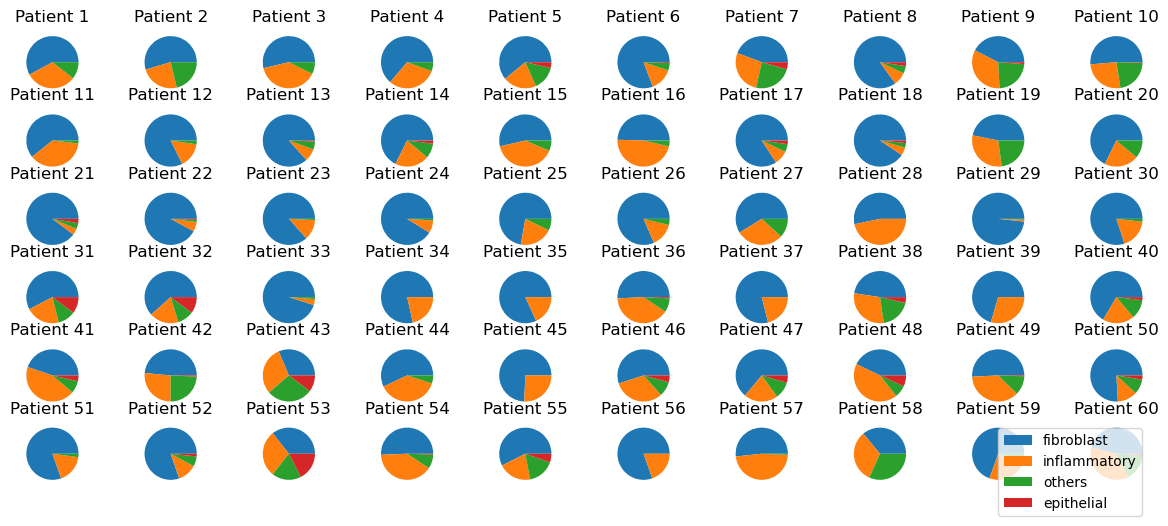

In [591]:

fig = plt.figure(figsize=(15,10))
for i, (patient_id, group) in enumerate(main_data.groupby("patientID")):
    cell_type_counts = group["cellTypeName"].value_counts()
    ax = fig.add_subplot(10,10, i+1)
    
    ax.pie(cell_type_counts)
    ax.set_title(f"Patient {patient_id}")
plt.legend(main_data["cellTypeName"].unique())
plt.show()

We have identified that there are 60 unique patients in our dataset, with multiple cells allocated to each patient.
Not every patient has epithelial cells. This opens a possibility for uneven distribution of cell types.
To avoid data leakage, we need to group any data for each patient and split the data such that there is no overlap of patient data between train, validation and test sets.
Additionally, we individually split main and extra data with different stratification methods, and then combine them.

One more problem is ensuring that we maintain a rough 60-20-20 split, as certain patients may contain a larger proportion of the dataset, which may cause uneven distribution. This is another reason we specify a random state

Stratified sampling is important so we get a good representation of all cell types in our train, test and val data.
Since all isCancerous cells are also epithelial in the main data, it naturally gets stratified correctly.
Extra data cannot stratify based on cell type, so we stratify on isCancerous instead. 



In [531]:
# 60-20-20 split
def group_split(test_size, data):
    # Reset the index of the DataFrame
    data.reset_index(drop=True, inplace=True)
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

    # Split the data into training and test sets
    for train_idx, test_idx in gss.split(data, groups=data['patientID']):
        train_data = data.loc[train_idx]
        test_data = data.loc[test_idx]
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

# def stratified_group_split(test_size, data, strat_col):
#     # Reset index for the group shuffle split
#     data.reset_index(drop=True, inplace=True)
    
#     # Create Stratified Group K-Fold
#     stratified_group = StratifiedGroupKFold(n_splits=int(1/test_size), shuffle=True, random_state=15)
    
#     for train_idx, test_idx in stratified_group.split(data, y=data[strat_col], groups=data['patientID']):
#         train_data = data.loc[train_idx]
#         test_data = data.loc[test_idx]
#         # We only need the first split
#         break 
    
#     return train_data.reset_index(drop=True), test_data.reset_index(drop=True)


train_main, test_main = group_split(0.2, main_data)
train_main, val_main = group_split(0.25, train_main)

train_extra, test_extra = group_split(0.2, extra_data)
train_extra, val_extra = group_split(0.25, train_extra)

# now we have stratified to the best of our ability
# we can combine isCancerous to get the full dataset
train_full_data = pd.concat([train_main, train_extra]).drop(['cellType', 'cellTypeName'], axis=1)
test_full_data = pd.concat([test_main, test_extra]).drop(['cellType', 'cellTypeName'], axis=1)
val_full_data = pd.concat([val_main, val_extra]).drop(['cellType', 'cellTypeName'], axis=1)
full_data = pd.concat([main_data, extra_data]).drop(['cellType', 'cellTypeName'], axis=1)

# train_main, test_main = stratified_group_split(0.2, main_data, 'cellTypeName')
# train_main, val_main = stratified_group_split(0.25, train_main, 'cellTypeName')

# train_extra, test_extra = stratified_group_split(0.2, extra_data, 'isCancerous')
# train_extra, val_extra = stratified_group_split(0.25, train_extra, 'isCancerous')

# # now we have stratified to the best of our ability
# # we can combine isCancerous to get the full dataset
# train_full_data = pd.concat([train_main, train_extra]).drop(['cellType', 'cellTypeName'], axis=1)
# test_full_data = pd.concat([test_main, test_extra]).drop(['cellType', 'cellTypeName'], axis=1)
# val_full_data = pd.concat([val_main, val_extra]).drop(['cellType', 'cellTypeName'], axis=1)
# full_data = pd.concat([main_data, extra_data]).drop(['cellType', 'cellTypeName'], axis=1)



MAIN DATA
There are 60 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.57
Test proportion: 0.19
Validation proportion: 0.24

FULL DATA
There are 98 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.57
Test proportion: 0.20
Validation proportion: 0.23

EXTRA DATA
There are 38 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.56
Test proportion: 0.22
Validation proportion: 0.22


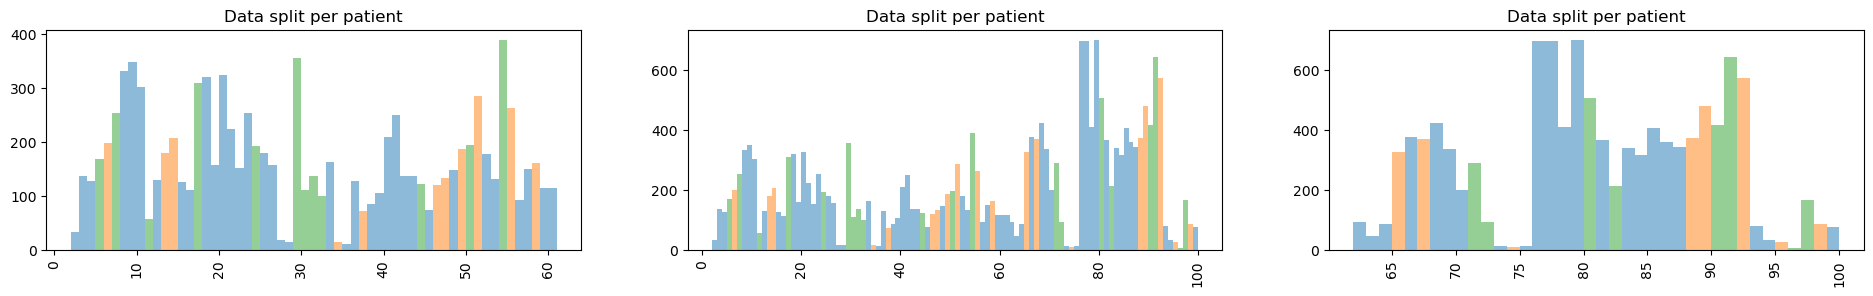

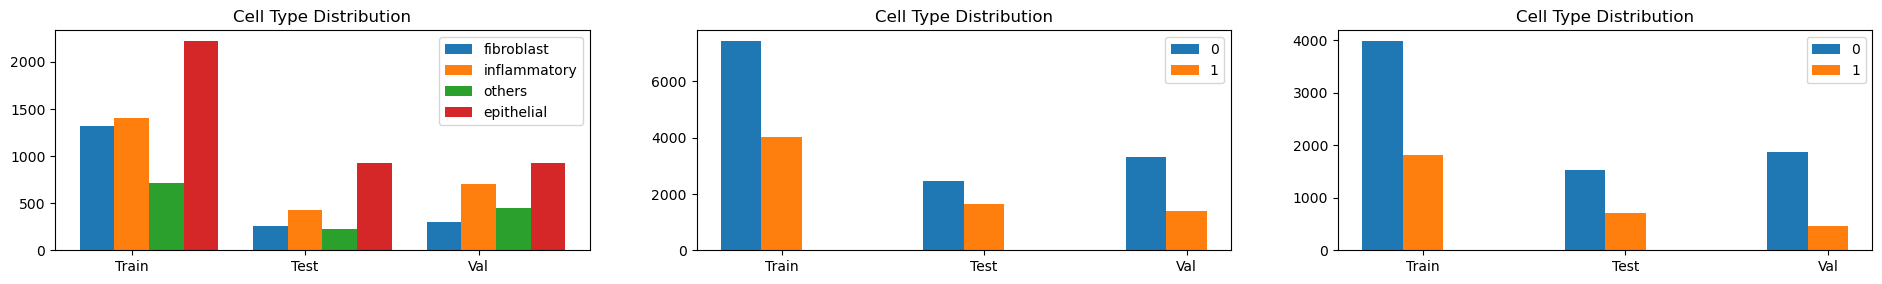

In [602]:
def split_verification(train_data, test_data, val_data, data):   
    train_patients = train_data['patientID'].unique()
    test_patients = test_data['patientID'].unique()
    val_patients = val_data['patientID'].unique()
    all_patients = np.unique(np.concatenate((train_patients, test_patients, val_patients), axis=0))
    print(f"There are {len(all_patients)} unique patients after splitting, spread across the train, test and validation sets.")

    def overlap(train_data, test_data):
        train_patients = train_data['patientID'].unique()
        test_patients = test_data['patientID'].unique()
        return len(np.intersect1d(train_patients, test_patients))

    print(f"There is {overlap(train_data, test_data)} overlap between the train and test patient data")
    print(f"There is {overlap(train_data, val_data)} overlap between the train and validation patient data\n")

    # Calculate the proportions of each dataset
    train_prop = len(train_data) / len(data)
    test_prop = len(test_data) / len(data)
    val_prop = len(val_data) / len(data)

    print(f"Train proportion: {train_prop:.2f}")
    print(f"Test proportion: {test_prop:.2f}")
    print(f"Validation proportion: {val_prop:.2f}")

def plot_patient_data_split(train_data, test_data, val_data, data):
    all_patients = data['patientID'].unique()
    plt.hist(train_data['patientID'], bins = all_patients+1, alpha=0.5)
    plt.hist(test_data['patientID'], bins = all_patients+1, alpha=0.5)
    plt.hist(val_data['patientID'], bins = all_patients+1, alpha=0.5)
    plt.title('Data split per patient')
    plt.xticks(rotation='vertical')

def plot_data_split_strat_col(train_data, test_data, val_data, strat_col):
    datasets = ['Train', 'Test', 'Val']
    bar_width = 0.2

    categories = train_data[strat_col].unique()
    for i, category in enumerate(categories):
        counts = [dataset[strat_col].value_counts().get(category, 0) for dataset in [train_data, test_data, val_data]]
        plt.bar(np.arange(len(datasets)) + i*bar_width, counts, width=bar_width, label=category)

    plt.title('Cell Type Distribution')
    plt.legend()
    plt.xticks(np.arange(len(datasets)) + bar_width, datasets)

print("MAIN DATA")
split_verification(train_main, test_main, val_main, main_data)
print("\nFULL DATA")
split_verification(train_full_data, test_full_data, val_full_data, full_data)
print("\nEXTRA DATA")
split_verification(train_extra, test_extra, val_extra, extra_data)

plt.figure(figsize=(40,20))
plt.subplot(6,5,1)
plot_patient_data_split(train_main, test_main, val_main, main_data)
plt.subplot(6,5,2)
plot_patient_data_split(train_full_data, test_full_data, val_full_data, full_data)
plt.subplot(6,5,3)
plot_patient_data_split(train_extra, test_extra, val_extra, extra_data)

plt.figure(figsize=(40, 20))
plt.subplot(6,5,1)
plot_data_split_strat_col(train_main, test_main, val_main, 'cellTypeName')
plt.subplot(6,5,2)
plot_data_split_strat_col(train_full_data, test_full_data, val_full_data, 'isCancerous')
plt.subplot(6,5,3)
plot_data_split_strat_col(train_extra, test_extra, val_extra, 'isCancerous')

# Data Augmentation
"For both networks, we arbitrary rotated patches (0◦, 90◦, 180◦, 270◦) and flipped them along vertical or horizontal axis to alleviate the rotation-variant problem of the input features."

In [533]:
# baseline colour perturbation specified
def perturb_color(img):
    img_uint8 = (img * 255).astype('uint8')
    img = Image.fromarray(img_uint8)
    img = img.convert('HSV')
    rH = np.random.uniform(0.95, 1.05)
    rS = np.random.uniform(0.9, 1.1)
    rV = np.random.uniform(0.9, 1.1)
    img_hsv = np.array(img)
    img_hsv[..., 0] = np.clip(img_hsv[..., 0] * rH, 0, 179)
    img_hsv[..., 1] = np.clip(img_hsv[..., 1] * rS, 0, 255)
    img_hsv[..., 2] = np.clip(img_hsv[..., 2] * rV, 0, 255)
    img_rgb = Image.fromarray(img_hsv, mode='HSV').convert('RGB')
    img_array = np.array(img_rgb) / 255.0
    return img_array

As there are too many images to open directly, we need a generator function to help us.
By specifying the column as 'isCanerous' or 'cellTypeName' the generator chooses the correct Class Mode, and the train and validation data.
Categorical class mode, but pass the string labels in, as Keras will handle one-hot encoding. This is better than using sparse.
shuffle allows us to plot metrics by consistent prediction on the model
extra_data_only allows us to change the dataset for training for isCancerous accuracy. If we need to pretrain for cellType, we should only use extra_data to avoid data leakage.

In [737]:

def generator(batch_size, y_col, shuffle=True, extra_data_only=False, oversampler=None):
    # depending on the task, we specify how to classify, as well as what data to pass in
    if y_col == 'isCancerous':
        class_mode = 'binary'
        gen_train_data = train_extra if extra_data_only else train_full_data
        gen_val_data = val_extra if extra_data_only else val_full_data
        gen_test_data = test_extra if extra_data_only else test_full_data

        if oversampler:
            gen_train_data = oversampler(gen_train_data)
    elif y_col == 'cellTypeName' or y_col == 'cellType':
        # Keras will handle one-hot encoding for us
        class_mode = 'sparse'
        gen_train_data = train_main
        gen_val_data = val_main
        gen_test_data = test_main


    train_datagen = ImageDataGenerator(
        rescale=1./255, 
        data_format='channels_last', 
        rotation_range=90, 
        horizontal_flip=True, 
        vertical_flip=True,
    #     preprocessing_function=lambda x: perturb_color(x)
    )

    val_datagen = ImageDataGenerator(
        rescale=1./255, 
        data_format='channels_last'
    )

    test_datagen = ImageDataGenerator(
        rescale=1./255, 
        data_format='channels_last'
    )

    train_generator = train_datagen.flow_from_dataframe(
            dataframe=gen_train_data,
            directory='Image_classification_data/patch_images',
            x_col="ImageName",
            y_col=y_col,
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode=class_mode,
            # must set shuffle to false for evaluation
            shuffle=shuffle
    )

    val_generator = val_datagen.flow_from_dataframe(
            dataframe=gen_val_data,
            directory='Image_classification_data/patch_images',
            x_col="ImageName",
            y_col=y_col,
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode=class_mode,
            shuffle=shuffle
    )

    test_generator = test_datagen.flow_from_dataframe(
            dataframe=gen_test_data,
            directory='Image_classification_data/patch_images',
            x_col="ImageName",
            y_col=y_col,
            target_size=(27, 27),
            batch_size=batch_size,
            class_mode=class_mode,
            shuffle=shuffle
    )
    return train_generator, val_generator, test_generator


We will attempt to use (based on section V of http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf)

Section VI C
- "We initialized all weights with 0 mean and 10^−2 standard deviation Gaussian random numbers. All biases were set to 0."
- "The networks were trained using stochastic gradient descent with momentum 0.9 and weight decay 5 × 10−4 for 120 epochs. We annealed the learning rate, starting from 10−2 for the first 60 epochs, then 10−3 for the next 40 epochs, and 10−4 for the last 20 epochs." SGD for optimizer with custom momentum, weight decay and lr_scheduler.
- "We used 20% of training data for validation."
- "The optimal networks for softmax CNN were selected based on the classification error on the validation set, respectively."
- "In both networks, a rectified linear unit (ReLU)
activation function [32] was used after each convolution layer
and the first two fully-connected layers (1st, 3rd, 5th and 6th
layer)."
- "To avoid over-fitting, dropout [33] was implemented in
the first-two fully-connected layers (5th and 6th layer, after
ReLU is applied) with a dropout rate of 0.2."

- Softmax CNN for the output layer
- Cross-entropy (The following logarithmic loss is employed to train the network via solving)

| Layer | Type       | Filter Dimensions | Input/Output Dimensions |
|-------|------------|------------------|-------------------------|
| 0     | Input      | -                | 27 X 27 X 1             |
| 1     | Convolution| 4 X 4 X 1 X 36         | 24 X 24 X 36            |
| 2     | Max-pooling| 2 X 2            | 12 X 12 X 36            |
| 3     | Convolution| 3 X 3 X 36 X 48   | 10 X 10 X 48            |
| 4     | Max-pooling| 2 X 2            | 5 X 5 x 48              |
| 5     | Fully-connected | 5 X 5 X 48 X 512   | 1 x 512                 |
| 6     | Fully-connected | 1 X 1 X 512 X 512  | 1 X 512                 |
| 7     | Fully-connected | 1 X 1 X 512 X 4    | 1 X 4                   |

Considerations: input dimension of 27x27x1 implies only 1 channel,  while the RGB images have 3. This implies the CNN can only see the intensity of the image, but not the colour information, which is important for determining the cell type.

In [773]:
def softmax_CNN(y_col, input_shape, optimizer, fully_connected_units, dropout, dropLastLayer = False):

    if y_col == 'isCancerous':
        units = 1
        activation = 'sigmoid'
        loss = 'binary_crossentropy'
    elif y_col == 'cellTypeName' or y_col == 'cellType':
        units = 4
        activation = 'softmax'
        loss = 'sparse_categorical_crossentropy'
        
    model = Sequential()
    # Convolutional Layer 1 (4x4x1x36)
    model.add(Conv2D(filters=36, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
    # Max Pooling Layer 2 (2x2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Convolutional Layer 3 (3x3x36x48)
    model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='relu'))
    # Max Pooling Layer 4 (2x2)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # # flatten H X W x Channels to 1D 
    model.add(Flatten())
    # Fully Connected Layer 5 (5x5x48x512)
    model.add(Dense(units=fully_connected_units, activation='relu'))
    model.add(Dropout(dropout))
    if dropLastLayer:
        # Fully Connected Layer 6 (1x1x512x512)
        model.add(Dense(units=fully_connected_units, activation='relu'))
        model.add(Dropout(dropout))
    # Output Layer 7 (1x1x512x4)
    model.add(Dense(units=units, activation=activation))

    #initialize weights and biases according to paper specifications
    # for layer in model.layers:
    #     if hasattr(layer, 'kernel_initializer'):
    #         layer.kernel_initializer = RandomNormal(mean=0.0, stddev=0.01)
    #         layer.bias_initializer = Zeros()

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# sourced from Week 10 demo
def train_val_accuracy(history):

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'r--')
    plt.plot(history.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], 'r--')  # Replace train_accuracy with 'categorical_accuracy'
    plt.plot(history.history['val_accuracy'], 'b--')  # Replace val_accuracy with 'val_categorical_accuracy'
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_metrics(generator, model, y_col):
    # Get the labels in the order they were fed to the model
    class_indices = generator.class_indices
    categories = [k for k, _ in sorted(class_indices.items(), key=lambda item: item[1])]

    pred_probs = model.predict(generator)
    pred_labels = np.round(pred_probs) if y_col == 'isCancerous' else np.argmax(pred_probs, axis=1)
    true_labels = generator.classes

    # Plot the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    figsize = (4,4)
    plt.figure(figsize=figsize)
    font_size = min(14, max(5, int(figsize[0] * 1.5)))
    plt.xticks(fontsize=font_size) 
    plt.yticks(fontsize=font_size)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    print(f"Weighted average F1-score: {f1_score(true_labels, pred_labels, average='weighted')}")
    print(f"Multiclass AUC: {roc_auc_score(true_labels, pred_probs, multi_class='ovr')}")

In [597]:
# the paper specifies different learning rates based on epoch
def lr_scheduler(epoch):
    if epoch < 60:
        return 0.01
    elif epoch < 100:
        return 0.001
    else:
        return 0.0001
    
sgd = keras.optimizers.SGD(decay=0.0005, momentum=0.9)

baseline = softmax_CNN('cellTypeName', input_shape=(27,27,1), optimizer='SGD', fully_connected_units = 512, dropout = 0.2)
train_generator, val_generator, test_generator = generator(32, 'cellTypeName')
baseline_history = baseline.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[LearningRateScheduler(lr_scheduler)])
train_val_accuracy(baseline_history)


y_col for generator is cell type
Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/10
178/178 [==============================] - 14s 71ms/step - loss: 1.3227 - accuracy: 0.3920 - val_loss: 1.3393 - val_accuracy: 0.3898 - lr: 0.0100
Epoch 2/10
 97/178 [===============>..............] - ETA: 4s - loss: 1.3017 - accuracy: 0.3963

KeyboardInterrupt: 

y_col for generator is cell type
Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
75/75 [==============================] - 2s 30ms/step


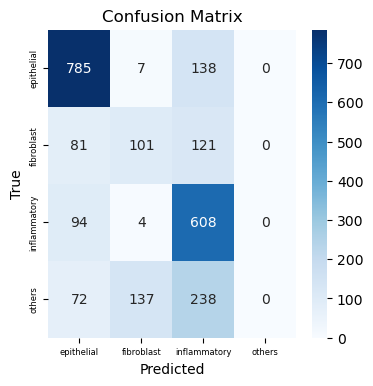

Weighted average F1-score: 0.5570474920706434
Multiclass AUC: 0.8355205416586093
58/58 [==============================] - 2s 33ms/step


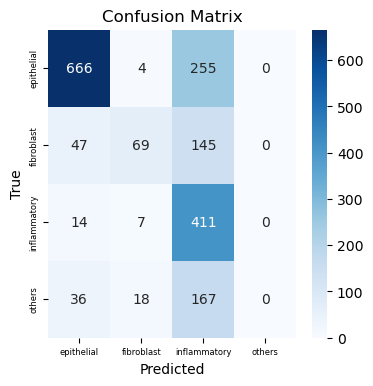

Weighted average F1-score: 0.5884135730994083
Multiclass AUC: 0.8015408156374122


In [ ]:
# to get samples in order
_, val_generator, test_generator = generator(32, 'cellTypeName', shuffle=False)
plot_metrics(val_generator, baseline)
plot_metrics(test_generator, baseline)

- need 3 dimensions
- use adam instead of SGD (automatically adapts learning rate, rather than manually annealing it), discovered only a year before this papers publication in 2015
- data augmentation

y_col for generator is cell type
Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/20
45/45 [==============================] - 13s 257ms/step - loss: 1.1473 - accuracy: 0.5257 - val_loss: 1.0187 - val_accuracy: 0.5373
Epoch 2/20
45/45 [==============================] - 11s 250ms/step - loss: 0.8930 - accuracy: 0.6616 - val_loss: 0.8763 - val_accuracy: 0.6274
Epoch 3/20
45/45 [==============================] - 11s 248ms/step - loss: 0.8197 - accuracy: 0.6882 - val_loss: 0.8392 - val_accuracy: 0.6601
Epoch 4/20
45/45 [==============================] - 11s 244ms/step - loss: 0.7694 - accuracy: 0.7071 - val_loss: 0.8649 - val_accuracy: 0.6484
Epoch 5/20
45/45 [==============================] - 11s 253ms/step - loss: 0.7797 - accuracy: 0.6992 - val_loss: 0.7897 - val_accuracy: 0.6781
Epoch 6/20
45/45 [==============================] - 11s 249ms/step - 

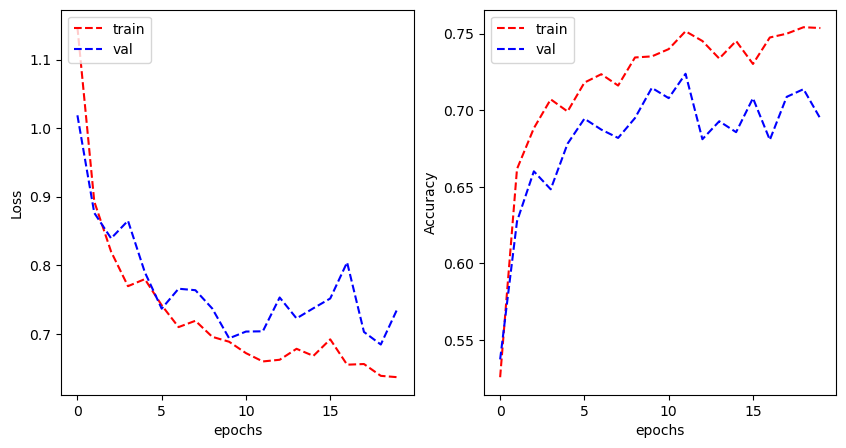

In [588]:
# the input shape will now take all 3 RGB channels
# no need to manually anneal learning rate, use ADAM
improved_CNN = softmax_CNN('cellTypeName', input_shape=(27,27,3), optimizer='adam', fully_connected_units=512, dropout=0.5, dropLastLayer=True)
train_generator, val_generator, _ = generator(128, 'cellTypeName')
improved_history = improved_CNN.fit(train_generator, epochs=20, validation_data=val_generator)
train_val_accuracy(improved_history)



y_col for generator is cell type
Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
19/19 [==============================] - 2s 105ms/step


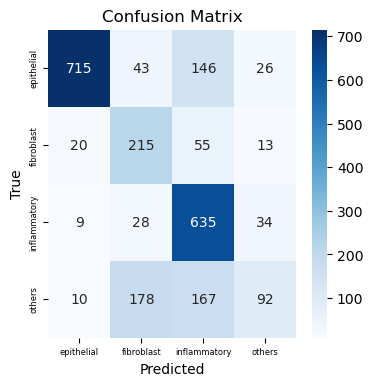

Weighted average F1-score: 0.6783883534909669
Multiclass AUC: 0.899236902277453
15/15 [==============================] - 2s 98ms/step


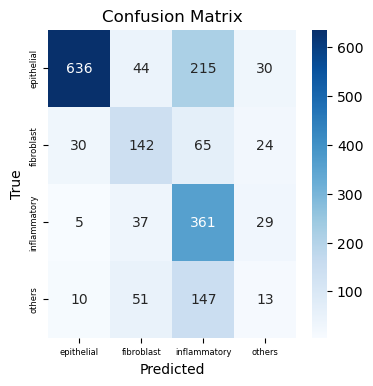

Weighted average F1-score: 0.62260053202572
Multiclass AUC: 0.8375543575251878


In [589]:
# to get samples in order
_, val_generator, test_generator = generator(128, 'cellTypeName', shuffle=False)
plot_metrics(val_generator, improved_CNN)
plot_metrics(test_generator, improved_CNN)




148/148 [==============================] - 5s 31ms/step


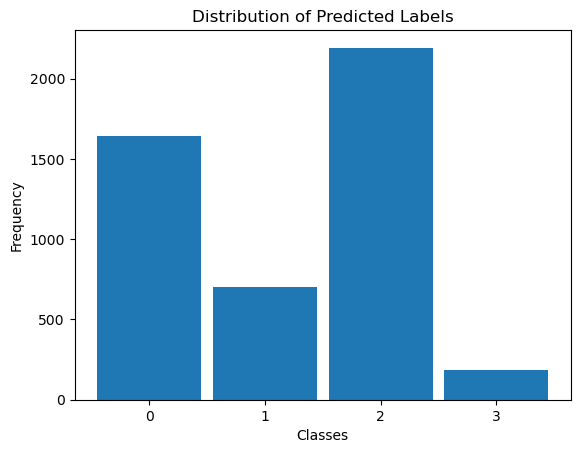

In [677]:
pred_probs = improved_CNN.predict(val_generator)
pred_labels = np.argmax(pred_probs, axis=1)
plt.hist(pred_labels, bins=np.arange(pred_probs.shape[1] + 1) - 0.5, rwidth=0.9)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Labels')
plt.xticks(np.unique(pred_labels))
plt.show()

Observations:
- Others cells seem to be incorrectly be predicted as fibroblast or inflammatory.
- The **class imbalance** in the bar chart earlier explains this.
  - our training data has a much higher distribution of other cells.
- This is an indication of requiring better sampling or more data by using extraData

The hope is using extra data has more isCancerous data, which corresponds to epithelial cells and can help the epithelial classification.

Try removing one layer
Try reducing the fully_connected_units
Most successful approaches also employ hard negative mining, an iterative process whereby false positives are added to the training data set for further training (14, 23, 24, 36).

Classifying isCancerous

The activation function in the final Dense layer should be 'sigmoid' instead of 'softmax'. The sigmoid function is used for binary classification because it squashes its input to the range [0, 1], which can be interpreted as a probability of the positive class.


In [717]:
full_data_CNN = softmax_CNN('isCancerous', input_shape=(27,27,3), optimizer='adam', fully_connected_units = 512, dropout = 0.2)
train_generator, val_generator, test_generator = generator(128, 'isCancerous')
full_data_CNN_history = baseline.fit(train_generator, epochs=10, validation_data=val_generator)
train_val_accuracy(baseline_history)

Found 11483 validated image filenames belonging to 2 classes.
Found 4717 validated image filenames belonging to 2 classes.
Found 4080 validated image filenames belonging to 2 classes.
Epoch 1/10
23/90 [======>.......................] - ETA: 14s - loss: 0.1636 - accuracy: 0.9317

KeyboardInterrupt: 

# Transfer Learning

Now that we have fine tuned models, we can consider using transfer learning of extra data onto the main data set.

Steps:
1. Pre-train our model using extra data
  - This avoids data leakage by training on the full data, as the cell type has to be trained on it later.
  - Rather than auto-encoding, we will simply use the isCancerous output layer. We expect the features for classifying cancer cells will help build features for the cell type.
2. Freeze the earlier dense layers.
  - Task-specific features to detect cancer are identified in the last few layers.
  - The general features in earlier layers can be kept for transfer learning.
3. Replace the isCancerous output layer for the celltypeName output layer.

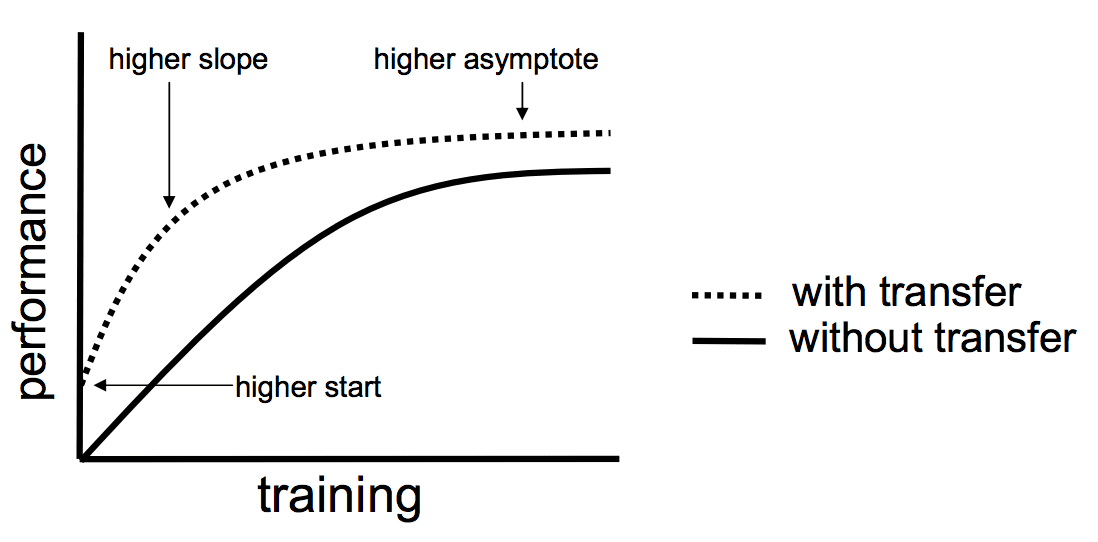

In [753]:
y_col = 'isCancerous'
batch_size = 128

extra_data_CNN = softmax_CNN(y_col, input_shape=(27,27,3), optimizer='adam', fully_connected_units = 512, dropout = 0.2)
train_generator, val_generator, test_generator = generator(batch_size, y_col, extra_data_only=True, oversampler=oversampled_gen_train)
extra_data_CNN_history = baseline.fit(train_generator, epochs=10, validation_data=val_generator)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)

plot_metrics(val_generator, extra_data_CNN, 'isCancerous')

pred_probs = extra_data_CNN.predict(val_generator)
print(max(pred_probs))
print(min(pred_probs))


1817
3995
2796
3995
Found 6791 validated image filenames belonging to 2 classes.
Found 2331 validated image filenames belonging to 2 classes.
Found 2241 validated image filenames belonging to 2 classes.
Epoch 1/10
 9/54 [====>.........................] - ETA: 10s - loss: 0.1254 - accuracy: 0.9514

KeyboardInterrupt: 

Over sampling:

- only use extra data to save training time and prevent overfitting.
- we ensure the data is 0.6 

Found 11907 validated image filenames belonging to 2 classes.
Found 4717 validated image filenames belonging to 2 classes.
Found 4080 validated image filenames belonging to 2 classes.
Epoch 1/10
94/94 [==============================] - 12s 126ms/step - loss: 0.2579 - accuracy: 0.8948 - val_loss: 0.2902 - val_accuracy: 0.8800
Epoch 2/10
94/94 [==============================] - 12s 128ms/step - loss: 0.1839 - accuracy: 0.9252 - val_loss: 0.2659 - val_accuracy: 0.9012
Epoch 3/10
94/94 [==============================] - 12s 128ms/step - loss: 0.1285 - accuracy: 0.9498 - val_loss: 0.2749 - val_accuracy: 0.9021
Epoch 4/10
94/94 [==============================] - 12s 131ms/step - loss: 0.1226 - accuracy: 0.9511 - val_loss: 0.2907 - val_accuracy: 0.8995
Epoch 5/10
94/94 [==============================] - 12s 132ms/step - loss: 0.1557 - accuracy: 0.9390 - val_loss: 0.2420 - val_accuracy: 0.9080
Epoch 6/10
94/94 [==============================] - 12s 132ms/step - loss: 0.1283 - accuracy: 0.9492 

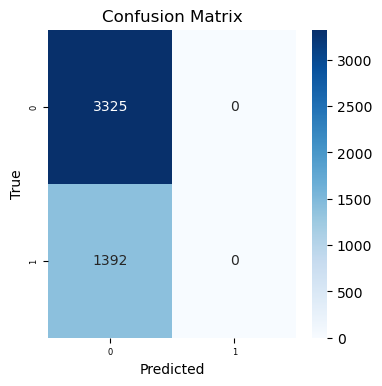

Weighted average F1-score: 0.582885631650709
Multiclass AUC: 0.604370624837957
37/37 [==============================] - 2s 55ms/step
[0.46070904]
[0.36363918]


In [772]:
def oversampled_gen_train(gen_train_data):
    # Assuming 'gen_train_data' is your training dataframe and 'isCancerous' is the column with your labels
    majority_class = gen_train_data[gen_train_data['isCancerous'] == '0']
    minority_class = gen_train_data[gen_train_data['isCancerous'] == '1']

    # Upsample minority class images to match the number of majority class images
    minority_class_upsampled = resample(minority_class, 
                                        replace=True,     
                                        n_samples=int(len(majority_class) * 0.6),  
                                        random_state=0)

    # Combine upsampled minority class and majority class
    gen_train_data = pd.concat([majority_class, minority_class_upsampled])
    majority_class = gen_train_data[gen_train_data['isCancerous'] == '0']
    minority_class = gen_train_data[gen_train_data['isCancerous'] == '1']
    return gen_train_data

y_col = 'isCancerous'
batch_size = 128

extra_data_CNN = softmax_CNN(y_col, input_shape=(27,27,3), optimizer='adam', fully_connected_units = 512, dropout = 0.2)
train_generator, val_generator, test_generator = generator(batch_size, y_col, extra_data_only=False, oversampler=oversampled_gen_train)
extra_data_CNN_history = baseline.fit(train_generator, epochs=10, validation_data=val_generator)

# to get samples in order
_, val_generator, test_generator = generator(batch_size, y_col, shuffle=False)

plot_metrics(val_generator, extra_data_CNN, 'isCancerous')
pred_probs = extra_data_CNN.predict(val_generator)
print(max(pred_probs))
print(min(pred_probs))

Model: "sequential_195"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_194 (Sequential)  (None, 1)                5312229   
                                                                 
 dense_487 (Dense)           (None, 4)                 8         
                                                                 
Total params: 5,312,237
Trainable params: 5,310,473
Non-trainable params: 1,764
_________________________________________________________________
y_col for generator is cell type
Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
Epoch 1/20
45/45 [==============================] - 13s 269ms/step - loss: 1.3839 - accuracy: 0.3851 - val_loss: 1.3760 - val_accuracy: 0.3898
Epoch 2/20
45/45 [==============================] - 12s 257ms/step - loss: 

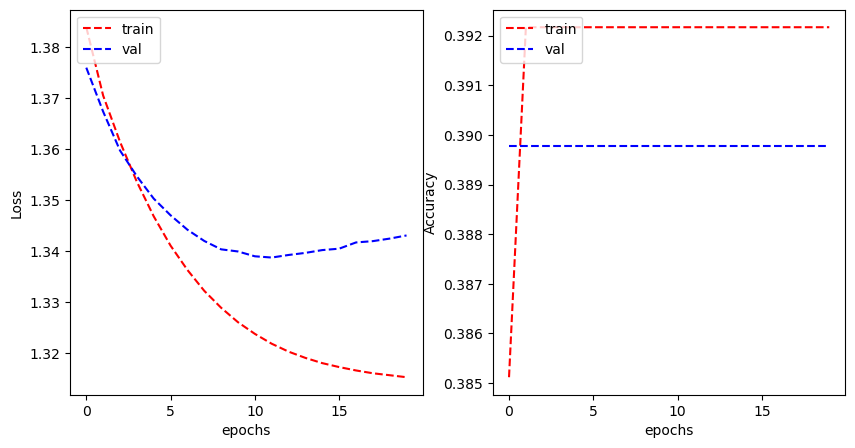

In [709]:
def transfer_model(model):
    # Freeze the layers except the last 4 layers (dense layers)
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:-4]:
        layer.trainable = False
    
    # replace the isCancerous output layer with the cellTypeName output layer
    model.layers.pop()
    transfer_model = Sequential()
    transfer_model.add(model)
    transfer_model.add(Dense(units=4, activation='softmax'))

    transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # # View the structure of the model
    transfer_model.summary()
    return transfer_model

# Create new generators for 'cellTypeName' prediction
transfer = transfer_model(extra_data_CNN)
train_generator, val_generator, test_generator = generator(128, 'cellTypeName')
transfer_history= transfer.fit(train_generator, epochs=20, validation_data=val_generator)
train_val_accuracy(transfer_history)

Observations:
- there is a disproportionate amount of isCancerous data in main data vs extra data. Simply using extra data would lead to most epithelial cells
- I unfroze more layers to allow more variability in training.
- I kept high dropout, this encourages the transfer model to evolve
 - these are typically active during training but not during validation/testing. This means the model might perform better on the validation set because it's effectively a "full-strength" version of your model, while during training the model is "weaker" due to dropout.
I increased the epochs as I noticed while the accuracy was stagnating, the loss was constantly decreasing.

y_col for generator is cell type
Found 5671 validated image filenames belonging to 4 classes.
Found 2386 validated image filenames belonging to 4 classes.
Found 1839 validated image filenames belonging to 4 classes.
19/19 [==============================] - 2s 96ms/step


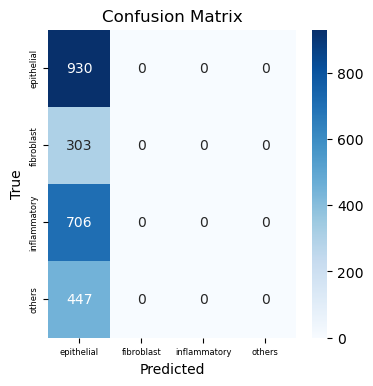

Weighted average F1-score: 0.21863059240826815
Multiclass AUC: 0.46424088683521625
15/15 [==============================] - 2s 97ms/step


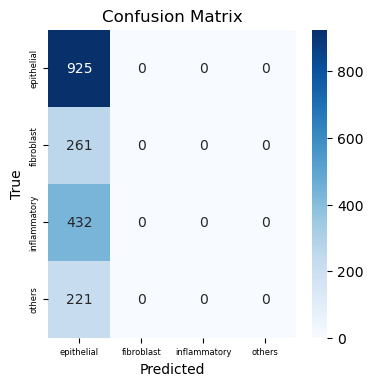

Weighted average F1-score: 0.3366616853524968
Multiclass AUC: 0.4967398591503964


In [673]:
# to get samples in order
_, val_generator, test_generator = generator(128, 'cellTypeName', shuffle=False)
plot_metrics(val_generator, transfer)
plot_metrics(test_generator, transfer)